# Пайплайн обучения моделей предсказания цен на квартиры в Москве

**Авторы:** Деружинский Дмитрий, Токарев Алексей  
**Проект:** Предсказание цен на квартиры в Москве

---

## Содержание

0. **Импорты и настройка окружения**
1. **Анализ датасета**
2. **Удаление выбросов**
3. **Разбиение на train/test/val и пайплайн предобработки**
4. **Пайплайн обучения**
5. **Пайплайн анализа результатов**
6. **Обучение моделей**
   - Линейная регрессия
   - CatBoost
   - Fully Connected Neural Network
7. **Оценка результатов**
8. **Выбор лучшей модели**


## 0. Импорты и настройка окружения


In [1]:
# Базовые библиотеки
import os
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# Модели машинного обучения
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

# Утилиты
import joblib
from typing import Dict, Tuple, List, Any
import json
from datetime import datetime

# Настройки
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Настройка отображения
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: f'{x:.2f}')

print("✅ Импорты загружены успешно")


✅ Импорты загружены успешно


In [2]:
# Фиксирование random seed для воспроизводимости
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

# Пути к файлам
PROJECT_ROOT = Path("..").resolve()
DATA_PATH = PROJECT_ROOT / "data" / "processed" / "moscow_housing_merged.csv"
MODELS_DIR = PROJECT_ROOT / "models"
MODELS_DIR.mkdir(exist_ok=True)

print(f"Random seed: {RANDOM_SEED}")
print(f"Project root: {PROJECT_ROOT}")
print(f"Data path: {DATA_PATH}")
print(f"Models directory: {MODELS_DIR}")


Random seed: 42
Project root: /Users/nznyx/Documents/ml/dir/DeruzhinksiiTokarevProjectML
Data path: /Users/nznyx/Documents/ml/dir/DeruzhinksiiTokarevProjectML/data/processed/moscow_housing_merged.csv
Models directory: /Users/nznyx/Documents/ml/dir/DeruzhinksiiTokarevProjectML/models


## 1. Анализ датасета


In [3]:
# Загрузка данных
df = pd.read_csv(DATA_PATH)

print(f"Размер датасета: {df.shape}")
print(f"\nКолонки: {list(df.columns)}")
print(f"\nПервые 5 строк:")
df.head()


Размер датасета: (43880, 7)

Колонки: ['price', 'total_area', 'rooms', 'floor', 'total_floors', 'subway_dist', 'year']

Первые 5 строк:


,price,total_area,rooms,floor,total_floors,subway_dist,year
0,31633073.00,64.20,2.00,11.00,16.00,2200.00,2024
1,29293000.00,78.10,2.00,9.00,27.00,825.00,2024
2,30349669.00,72.40,2.00,3.00,24.00,458.33,2024
3,31845511.00,69.20,2.00,2.00,12.00,1741.67,2024
4,38810000.00,66.90,2.00,9.00,14.00,2475.00,2024


In [4]:
# Общая информация о датасете
print("=== Информация о датасете ===\n")
print(df.info())
print("\n=== Статистика ===\n")
print(df.describe())


=== Информация о датасете ===

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43880 entries, 0 to 43879
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         43858 non-null  float64
 1   total_area    43857 non-null  float64
 2   rooms         41840 non-null  float64
 3   floor         43857 non-null  float64
 4   total_floors  41817 non-null  float64
 5   subway_dist   43733 non-null  float64
 6   year          43880 non-null  int64  
dtypes: float64(6), int64(1)
memory usage: 2.3 MB
None

=== Статистика ===

              price  total_area    rooms    floor  total_floors  subway_dist  \
count      43858.00    43857.00 41840.00 43857.00      41817.00     43733.00   
mean    31203720.48       66.78     1.99     8.37         16.15      1005.08   
std     72397017.37       55.37     1.27     7.72         10.14       551.83   
min           50.00        6.00     0.00    -1.00          1.00         0.00  

=== Пропущенные значения ===

        Колонка  Пропусков  Процент
4  total_floors       2063     4.70
2         rooms       2040     4.65
5   subway_dist        147     0.34
1    total_area         23     0.05
3         floor         23     0.05
0         price         22     0.05


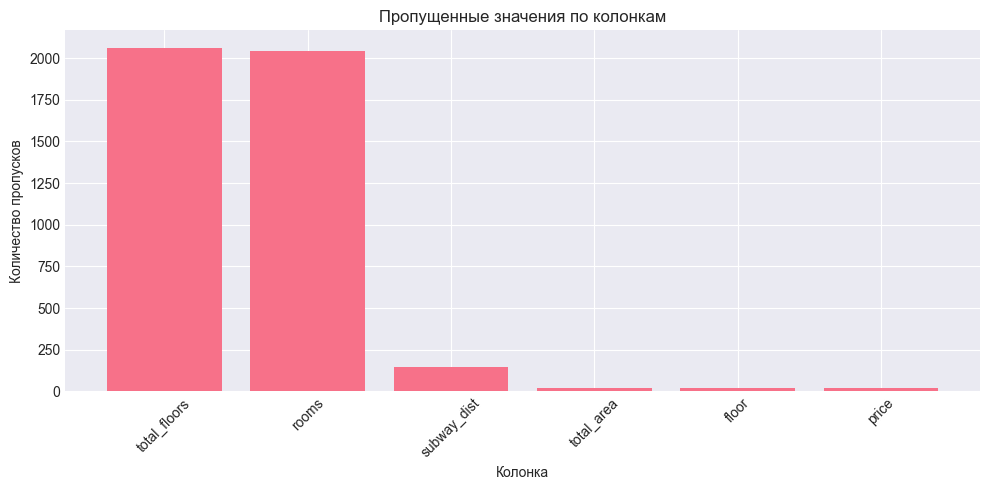

In [5]:
# Пропущенные значения
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100

missing_df = pd.DataFrame({
    'Колонка': missing.index,
    'Пропусков': missing.values,
    'Процент': missing_pct.values
})
missing_df = missing_df[missing_df['Пропусков'] > 0].sort_values('Пропусков', ascending=False)

print("=== Пропущенные значения ===\n")
print(missing_df)

# Визуализация
if len(missing_df) > 0:
    plt.figure(figsize=(10, 5))
    plt.bar(missing_df['Колонка'], missing_df['Пропусков'])
    plt.xlabel('Колонка')
    plt.ylabel('Количество пропусков')
    plt.title('Пропущенные значения по колонкам')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("✅ Пропусков нет")


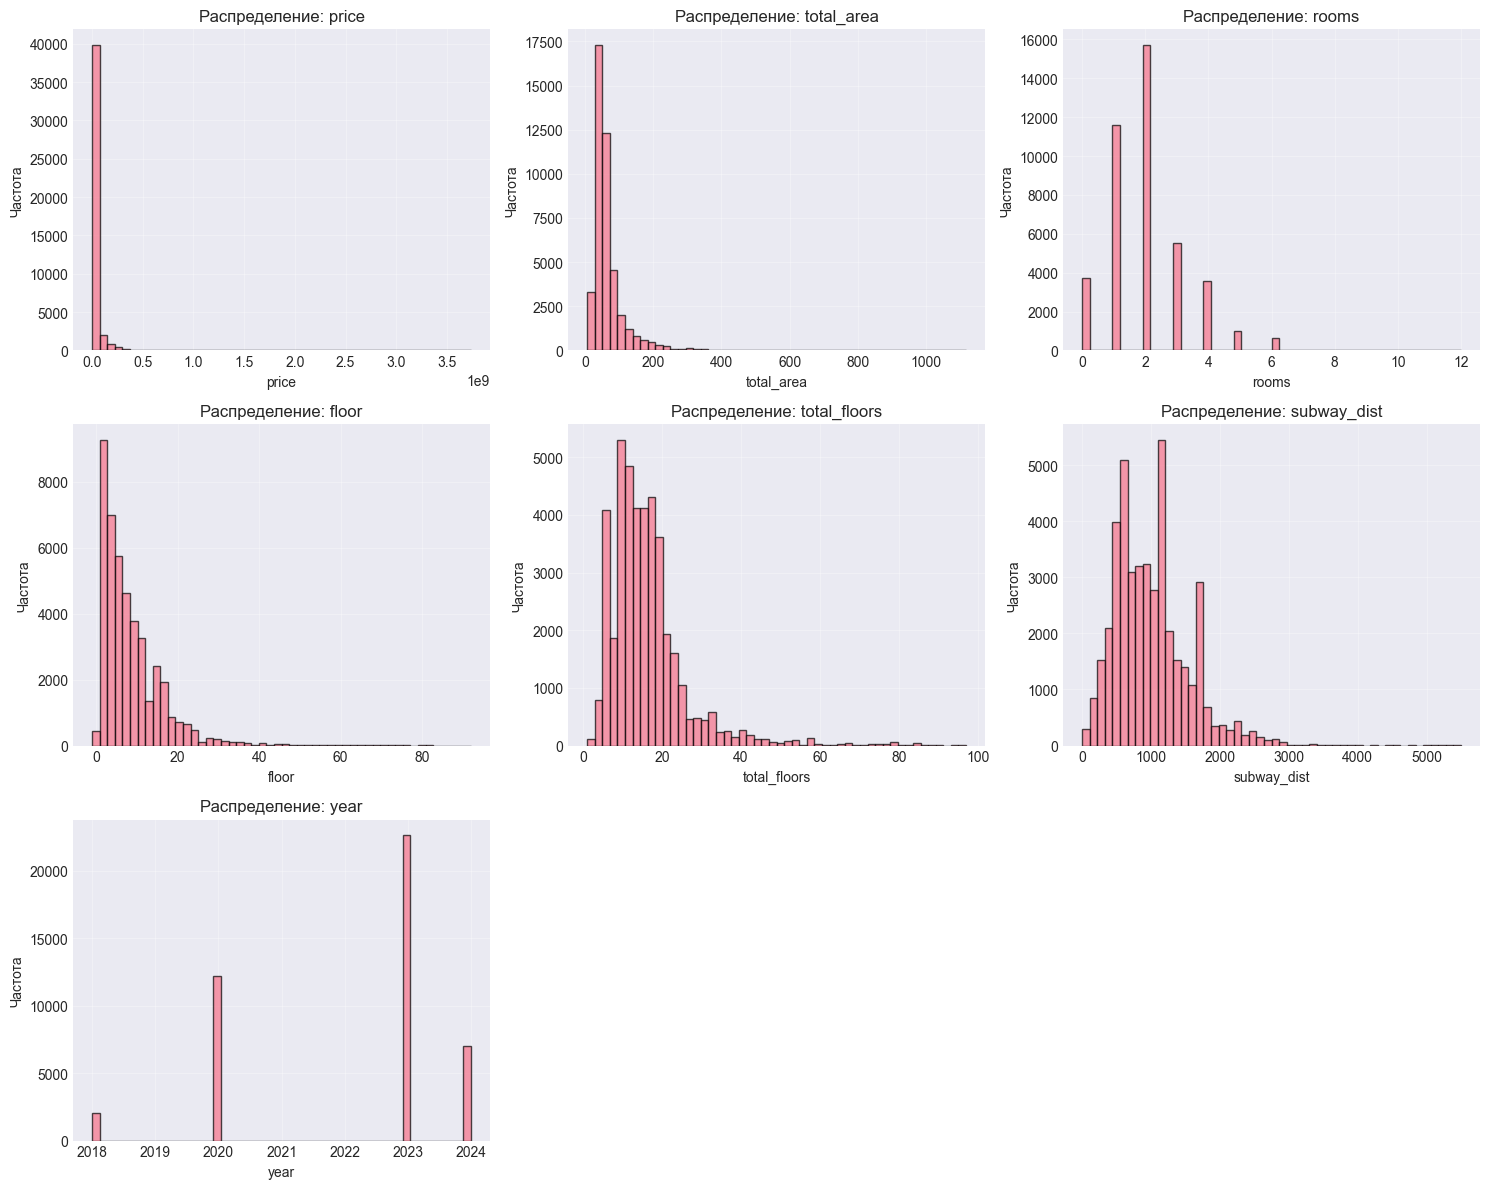

In [6]:
# Распределения признаков
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for idx, col in enumerate(df.columns):
    if idx < len(axes):
        axes[idx].hist(df[col].dropna(), bins=50, edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'Распределение: {col}')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Частота')
        axes[idx].grid(True, alpha=0.3)

# Убрать лишние подграфики
for idx in range(len(df.columns), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


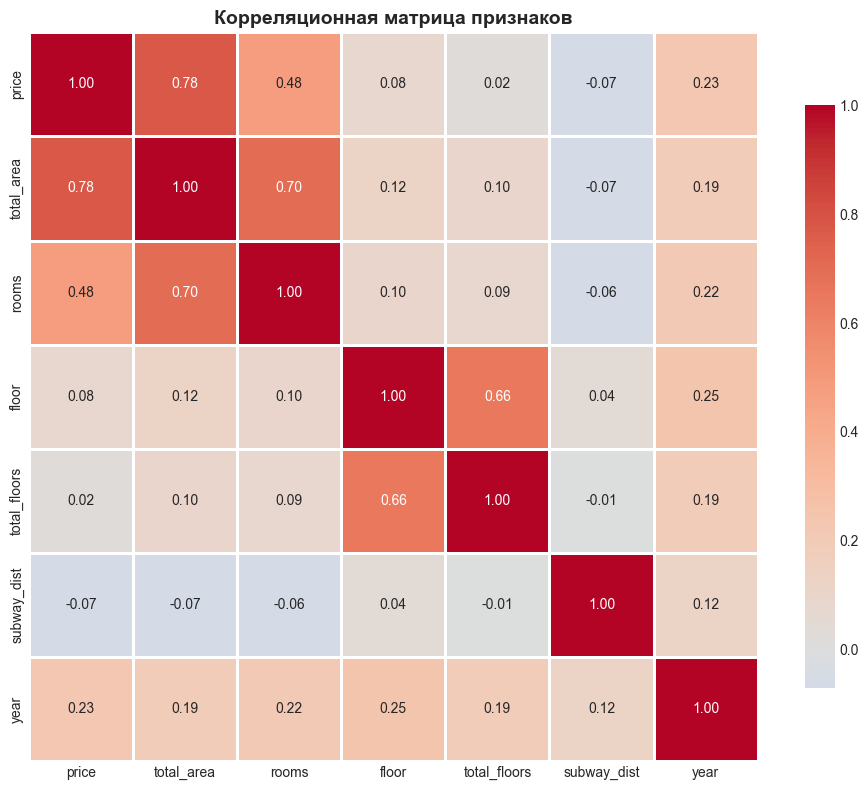


=== Корреляция признаков с ценой ===

price          1.00
total_area     0.78
rooms          0.48
year           0.23
floor          0.08
subway_dist    0.07
total_floors   0.02
Name: price, dtype: float64


In [7]:
# Корреляционная матрица
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Корреляционная матрица признаков', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Топ корреляций с ценой
price_corr = correlation_matrix['price'].abs().sort_values(ascending=False)
print("\n=== Корреляция признаков с ценой ===\n")
print(price_corr)


## 2. Удаление выбросов


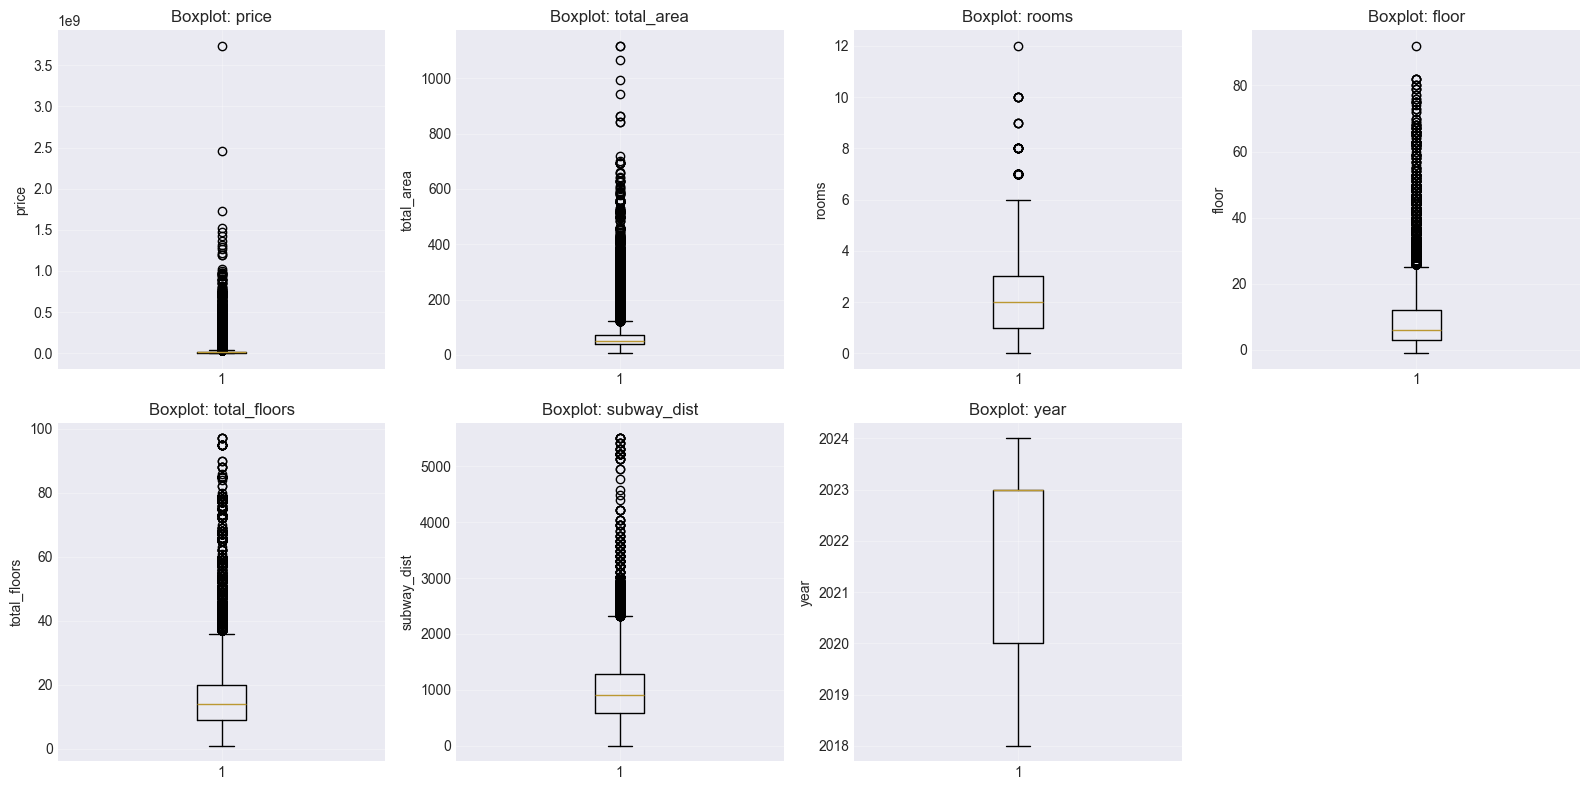

In [8]:
# Визуализация выбросов через boxplot
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, col in enumerate(df.columns):
    if idx < len(axes):
        axes[idx].boxplot(df[col].dropna(), vert=True)
        axes[idx].set_title(f'Boxplot: {col}')
        axes[idx].set_ylabel(col)
        axes[idx].grid(True, alpha=0.3)

# Убрать лишние подграфики
for idx in range(len(df.columns), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


In [9]:
# Функция для удаления выбросов методом IQR
def remove_outliers_iqr(data: pd.DataFrame, columns: List[str], multiplier: float = 1.5) -> pd.DataFrame:
    """
    Удаляет выбросы используя метод межквартильного размаха (IQR).
    
    Параметры:
        data: исходный DataFrame
        columns: список колонок для обработки
        multiplier: коэффициент для IQR (по умолчанию 1.5)
    
    Возвращает:
        DataFrame без выбросов
    """
    df_clean = data.copy()
    outliers_info = []
    
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        
        # Подсчет выбросов
        outliers_count = ((df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)).sum()
        
        # Удаление выбросов
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
        
        outliers_info.append({
            'Колонка': col,
            'Удалено выбросов': outliers_count,
            'Lower bound': lower_bound,
            'Upper bound': upper_bound
        })
    
    outliers_df = pd.DataFrame(outliers_info)
    print("=== Информация об удалении выбросов ===\n")
    print(outliers_df)
    print(f"\nИсходный размер: {len(data)}")
    print(f"Размер после очистки: {len(df_clean)}")
    print(f"Удалено строк: {len(data) - len(df_clean)} ({(len(data) - len(df_clean)) / len(data) * 100:.2f}%)")
    
    return df_clean

# Копия исходных данных
df_original = df.copy()

# Сначала удалим пропущенные значения
df_clean = df.dropna()
print(f"После удаления пропусков: {len(df_clean)} строк\n")

# Удаление выбросов для всех числовых колонок, КРОМЕ year и rooms
numeric_columns = df_clean.select_dtypes(include=[np.number]).columns.tolist()
# Исключаем year и rooms из удаления выбросов (это категориальные признаки)
columns_for_outlier_removal = [col for col in numeric_columns if col not in ['year', 'rooms']]
print(f"Колонки для удаления выбросов: {columns_for_outlier_removal}\n")
df_clean = remove_outliers_iqr(df_clean, columns_for_outlier_removal, multiplier=1.5)


После удаления пропусков: 41693 строк

Колонки для удаления выбросов: ['price', 'total_area', 'floor', 'total_floors', 'subway_dist']

=== Информация об удалении выбросов ===

        Колонка  Удалено выбросов  Lower bound  Upper bound
0         price              6211 -13066500.00  43679900.00
1    total_area              1069         2.50        94.50
2         floor               587       -10.50        25.50
3  total_floors               615        -6.00        34.00
4   subway_dist               848      -354.83      2302.50

Исходный размер: 41693
Размер после очистки: 32363
Удалено строк: 9330 (22.38%)


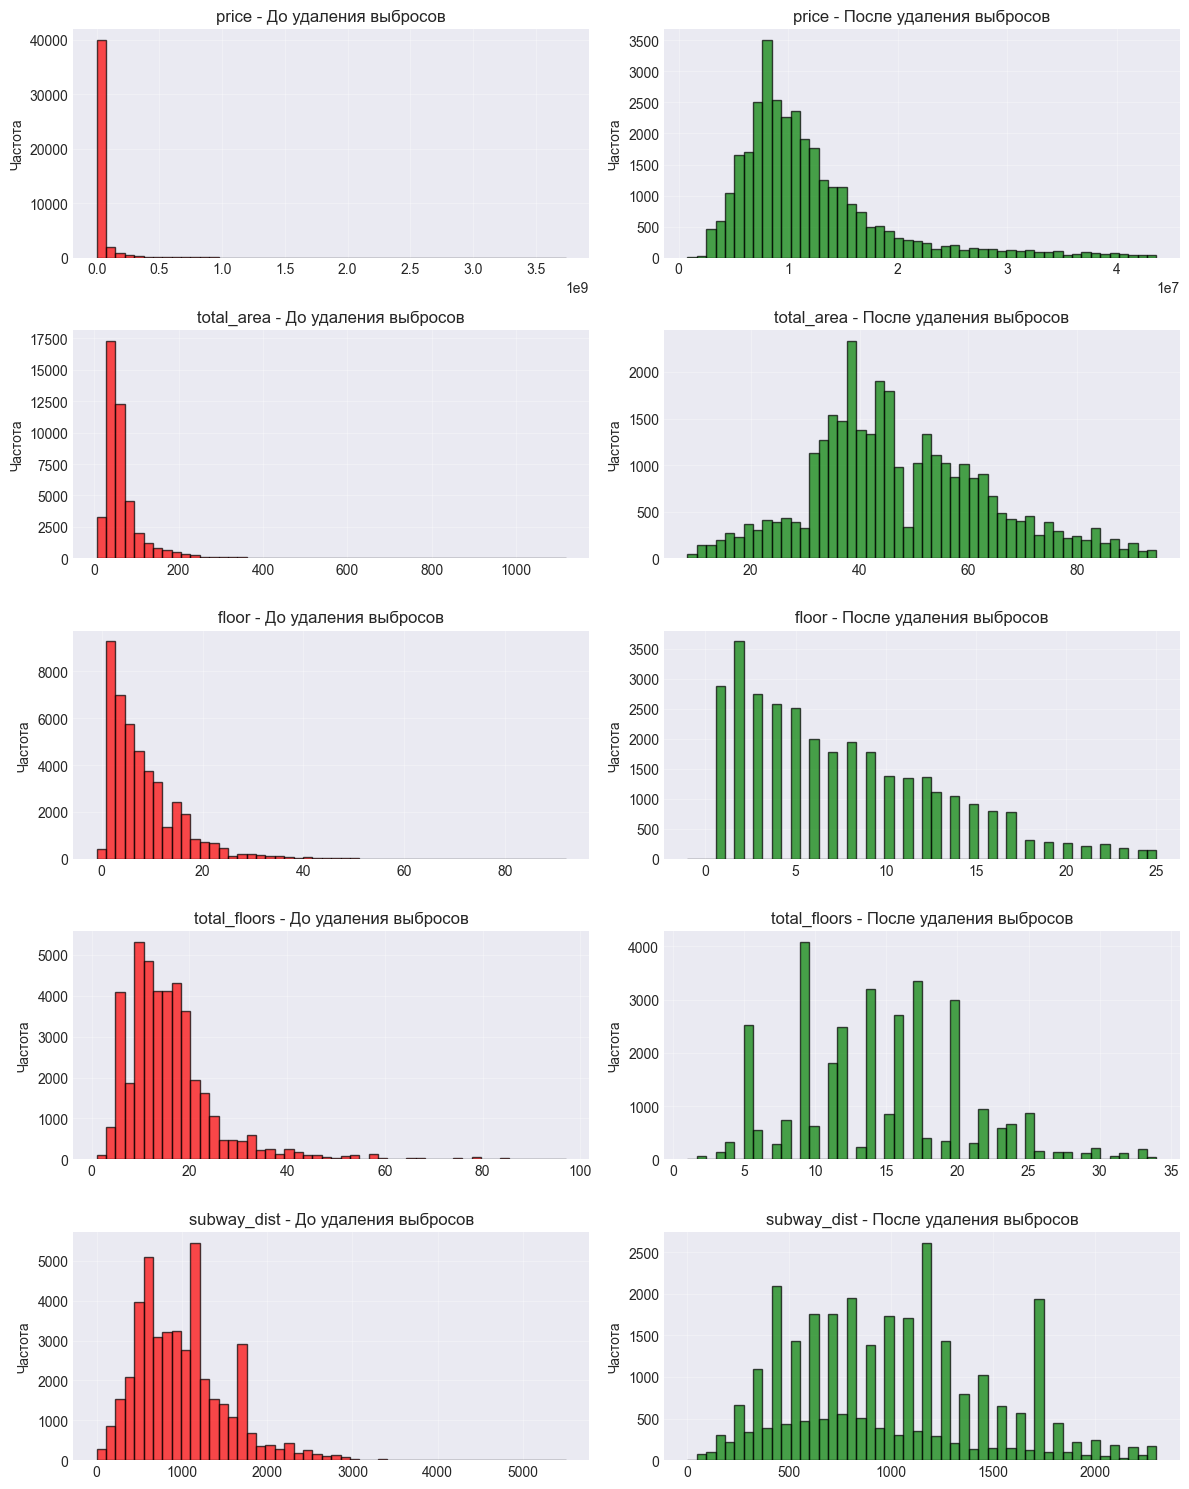


✅ Итоговый размер датасета: (32363, 7)
✅ Сохранены все значения для колонок: year, rooms


In [10]:
# Сравнение распределений до и после удаления выбросов (только для обработанных колонок)
fig, axes = plt.subplots(len(columns_for_outlier_removal), 2, figsize=(12, len(columns_for_outlier_removal) * 3))

# Если только одна колонка, axes не будет массивом
if len(columns_for_outlier_removal) == 1:
    axes = axes.reshape(1, -1)

for idx, col in enumerate(columns_for_outlier_removal):
    # До удаления выбросов
    axes[idx, 0].hist(df_original[col].dropna(), bins=50, edgecolor='black', alpha=0.7, color='red')
    axes[idx, 0].set_title(f'{col} - До удаления выбросов')
    axes[idx, 0].set_ylabel('Частота')
    axes[idx, 0].grid(True, alpha=0.3)
    
    # После удаления выбросов
    axes[idx, 1].hist(df_clean[col], bins=50, edgecolor='black', alpha=0.7, color='green')
    axes[idx, 1].set_title(f'{col} - После удаления выбросов')
    axes[idx, 1].set_ylabel('Частота')
    axes[idx, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Используем очищенные данные для дальнейшей работы
df = df_clean.copy()
print(f"\n✅ Итоговый размер датасета: {df.shape}")
print(f"✅ Сохранены все значения для колонок: year, rooms")


## 3. Разбиение на train/test/val и пайплайн предобработки


In [11]:
# Разделение на признаки и целевую переменную
X = df.drop('price', axis=1)
y = df['price']

print(f"Признаки (X): {X.shape}")
print(f"Целевая переменная (y): {y.shape}")
print(f"\nНазвания признаков: {list(X.columns)}")


Признаки (X): (32363, 6)
Целевая переменная (y): (32363,)

Названия признаков: ['total_area', 'rooms', 'floor', 'total_floors', 'subway_dist', 'year']


In [12]:
# Разбиение данных на train/test/val
# Сначала разделим на train+val и test (80% / 20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, shuffle=True
)

# Затем разделим train+val на train и val (70% / 10% от исходного)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.125, random_state=RANDOM_SEED, shuffle=True  # 0.125 * 0.8 = 0.1
)

print("=== Размеры выборок ===")
print(f"Train: {X_train.shape[0]} образцов ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Val:   {X_val.shape[0]} образцов ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test:  {X_test.shape[0]} образцов ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"Всего: {X_train.shape[0] + X_val.shape[0] + X_test.shape[0]} образцов")


=== Размеры выборок ===
Train: 22653 образцов (70.0%)
Val:   3237 образцов (10.0%)
Test:  6473 образцов (20.0%)
Всего: 32363 образцов


In [13]:
# Пайплайн предобработки данных
class DataPreprocessor:
    """Класс для предобработки данных"""
    
    def __init__(self, scaler_type='standard'):
        """
        Инициализация препроцессора.
        
        Параметры:
            scaler_type: тип скейлера ('standard', 'minmax', 'robust')
        """
        self.scaler_type = scaler_type
        self.scaler = None
        self.feature_names = None
        
    def fit(self, X_train):
        """Обучить скейлер на обучающей выборке"""
        from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
        
        if self.scaler_type == 'standard':
            self.scaler = StandardScaler()
        elif self.scaler_type == 'minmax':
            self.scaler = MinMaxScaler()
        elif self.scaler_type == 'robust':
            self.scaler = RobustScaler()
        else:
            raise ValueError(f"Неизвестный тип скейлера: {self.scaler_type}")
        
        self.scaler.fit(X_train)
        self.feature_names = X_train.columns.tolist() if hasattr(X_train, 'columns') else None
        
        return self
    
    def transform(self, X):
        """Применить скейлер к данным"""
        if self.scaler is None:
            raise ValueError("Сначала необходимо вызвать fit()")
        
        X_scaled = self.scaler.transform(X)
        return X_scaled
    
    def fit_transform(self, X):
        """Обучить и применить скейлер"""
        self.fit(X)
        return self.transform(X)
    
    def save(self, path):
        """Сохранить препроцессор"""
        joblib.dump(self, path)
        print(f"✅ Препроцессор сохранен: {path}")
    
    @staticmethod
    def load(path):
        """Загрузить препроцессор"""
        preprocessor = joblib.load(path)
        print(f"✅ Препроцессор загружен: {path}")
        return preprocessor

# Создание и обучение препроцессора
preprocessor = DataPreprocessor(scaler_type='standard')
X_train_scaled = preprocessor.fit_transform(X_train)
X_val_scaled = preprocessor.transform(X_val)
X_test_scaled = preprocessor.transform(X_test)

print("✅ Данные нормализованы")
print(f"Train: {X_train_scaled.shape}")
print(f"Val:   {X_val_scaled.shape}")
print(f"Test:  {X_test_scaled.shape}")

# Сохранение препроцессора
preprocessor.save(MODELS_DIR / "preprocessor.pkl")


✅ Данные нормализованы
Train: (22653, 6)
Val:   (3237, 6)
Test:  (6473, 6)
✅ Препроцессор сохранен: /Users/nznyx/Documents/ml/dir/DeruzhinksiiTokarevProjectML/models/preprocessor.pkl


In [14]:
# Универсальная функция обучения с валидацией и сохранением лучшей модели
def train_model(
    model,
    X_train, y_train,
    X_val, y_val,
    model_name: str,
    save_path: Path,
    monitor_metric: str = 'mae',  # 'mae', 'rmse', 'r2', 'mape'
    early_stopping_patience: int = None,
    verbose: bool = True
) -> Dict[str, Any]:
    """
    Универсальный пайплайн обучения модели с валидацией и сохранением лучшего чекпоинта.
    
    Параметры:
        model: модель для обучения (sklearn-like или PyTorch)
        X_train, y_train: обучающая выборка
        X_val, y_val: валидационная выборка
        model_name: имя модели для логирования
        save_path: путь для сохранения лучшей модели
        monitor_metric: метрика для отслеживания ('mae', 'rmse', 'r2', 'mape')
        early_stopping_patience: кол-во эпох для early stopping (для PyTorch)
        verbose: выводить ли информацию о процессе
    
    Возвращает:
        Словарь с результатами обучения
    """
    from time import time
    
    start_time = time()
    results = {
        'model_name': model_name,
        'train_metrics': {},
        'val_metrics': {},
        'training_time': 0,
        'best_checkpoint': str(save_path)
    }
    
    if verbose:
        print(f"\n{'='*60}")
        print(f"Обучение модели: {model_name}")
        print(f"{'='*60}")
    
    # Обучение модели
    try:
        model.fit(X_train, y_train)
        
        # Предсказания
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        
        # Вычисление метрик
        results['train_metrics'] = {
            'mae': mean_absolute_error(y_train, y_train_pred),
            'rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
            'r2': r2_score(y_train, y_train_pred),
            'mape': mean_absolute_percentage_error(y_train, y_train_pred) * 100
        }
        
        results['val_metrics'] = {
            'mae': mean_absolute_error(y_val, y_val_pred),
            'rmse': np.sqrt(mean_squared_error(y_val, y_val_pred)),
            'r2': r2_score(y_val, y_val_pred),
            'mape': mean_absolute_percentage_error(y_val, y_val_pred) * 100
        }
        
        # Сохранение модели
        joblib.dump(model, save_path)
        
    except Exception as e:
        print(f"❌ Ошибка при обучении: {e}")
        return results
    
    results['training_time'] = time() - start_time
    
    if verbose:
        print(f"\n📊 Метрики на обучающей выборке:")
        print(f"  MAE:  {results['train_metrics']['mae']:,.0f} ₽")
        print(f"  RMSE: {results['train_metrics']['rmse']:,.0f} ₽")
        print(f"  R²:   {results['train_metrics']['r2']:.4f}")
        print(f"  MAPE: {results['train_metrics']['mape']:.2f}%")
        
        print(f"\n📊 Метрики на валидационной выборке:")
        print(f"  MAE:  {results['val_metrics']['mae']:,.0f} ₽")
        print(f"  RMSE: {results['val_metrics']['rmse']:,.0f} ₽")
        print(f"  R²:   {results['val_metrics']['r2']:.4f}")
        print(f"  MAPE: {results['val_metrics']['mape']:.2f}%")
        
        print(f"\n⏱  Время обучения: {results['training_time']:.2f} сек")
        print(f"💾 Модель сохранена: {save_path}")
        print(f"{'='*60}\n")
    
    return results

print("✅ Пайплайн обучения готов")


✅ Пайплайн обучения готов


In [15]:
# Функция для анализа результатов модели
def analyze_model_results(
    model,
    X_test, y_test,
    model_name: str,
    X_scaled=True
) -> Dict[str, float]:
    """
    Анализ результатов модели на тестовой выборке.
    
    Параметры:
        model: обученная модель
        X_test, y_test: тестовая выборка
        model_name: имя модели
        X_scaled: нормализованы ли данные
    
    Возвращает:
        Словарь с метриками
    """
    print(f"\n{'='*60}")
    print(f"Анализ модели: {model_name}")
    print(f"{'='*60}")
    
    # Предсказания
    y_pred = model.predict(X_test)
    
    # Вычисление метрик
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    
    print(f"\n📊 Метрики на тестовой выборке:")
    print(f"  MAE:  {mae:,.0f} ₽")
    print(f"  RMSE: {rmse:,.0f} ₽")
    print(f"  R²:   {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    
    # Визуализация 1: Предсказания vs Реальные значения
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # График 1: Scatter plot
    axes[0].scatter(y_test, y_pred, alpha=0.5, s=10)
    axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                 'r--', lw=2, label='Идеальное предсказание')
    axes[0].set_xlabel('Реальные значения')
    axes[0].set_ylabel('Предсказанные значения')
    axes[0].set_title(f'{model_name}: Предсказания vs Реальные значения')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # График 2: Residuals (остатки)
    residuals = y_test - y_pred
    axes[1].scatter(y_pred, residuals, alpha=0.5, s=10)
    axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[1].set_xlabel('Предсказанные значения')
    axes[1].set_ylabel('Остатки (residuals)')
    axes[1].set_title(f'{model_name}: Анализ остатков')
    axes[1].grid(True, alpha=0.3)
    
    # График 3: Распределение ошибок
    axes[2].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
    axes[2].axvline(x=0, color='r', linestyle='--', lw=2)
    axes[2].set_xlabel('Остатки')
    axes[2].set_ylabel('Частота')
    axes[2].set_title(f'{model_name}: Распределение ошибок')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Визуализация 2: Процентильные ошибки
    absolute_percentage_errors = np.abs((y_test - y_pred) / y_test) * 100
    percentiles = [10, 25, 50, 75, 90, 95, 99]
    percentile_values = np.percentile(absolute_percentage_errors, percentiles)
    
    print(f"\n📈 Процентильные ошибки (%):")
    for p, val in zip(percentiles, percentile_values):
        print(f"  {p}%:  {val:.2f}%")
    
    plt.figure(figsize=(10, 5))
    plt.bar([str(p) for p in percentiles], percentile_values, edgecolor='black', alpha=0.7)
    plt.xlabel('Процентиль')
    plt.ylabel('Абсолютная процентная ошибка (%)')
    plt.title(f'{model_name}: Процентильные ошибки')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    print(f"{'='*60}\n")
    
    return {
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'mape': mape
    }

print("✅ Пайплайн анализа готов")


✅ Пайплайн анализа готов


## 6. Обучение моделей

Обучим несколько моделей регрессии:
1. **Linear Regression** - baseline модель
2. **Random Forest** - ансамбль решающих деревьев
3. **Gradient Boosting** (sklearn) - классический gradient boosting
4. **XGBoost** - экстремальный gradient boosting
5. **LightGBM** - быстрый gradient boosting от Microsoft
6. **CatBoost** - gradient boosting от Yandex
7. **SVR** (Support Vector Regression) - регрессия на основе SVM


In [16]:
# Словарь для хранения результатов всех моделей
all_results = {}


### 6.1 Линейная регрессия


In [17]:
# Создание и обучение модели линейной регрессии
lr_model = LinearRegression()

lr_results = train_model(
    model=lr_model,
    X_train=X_train_scaled,
    y_train=y_train.values,
    X_val=X_val_scaled,
    y_val=y_val.values,
    model_name="Linear Regression",
    save_path=MODELS_DIR / "linear_regression.pkl",
    verbose=True
)

all_results['Linear Regression'] = lr_results



Обучение модели: Linear Regression

📊 Метрики на обучающей выборке:
  MAE:  3,704,326 ₽
  RMSE: 5,357,232 ₽
  R²:   0.3967
  MAPE: 34.91%

📊 Метрики на валидационной выборке:
  MAE:  3,844,243 ₽
  RMSE: 5,554,737 ₽
  R²:   0.3476
  MAPE: 36.82%

⏱  Время обучения: 0.00 сек
💾 Модель сохранена: /Users/nznyx/Documents/ml/dir/DeruzhinksiiTokarevProjectML/models/linear_regression.pkl



### 6.2 CatBoost


In [18]:
# Создание и обучение CatBoost модели
catboost_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    l2_leaf_reg=3,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=RANDOM_SEED,
    verbose=100
)

print("Обучение CatBoost...")
catboost_model.fit(
    X_train_scaled, y_train.values,
    eval_set=(X_val_scaled, y_val.values),
    early_stopping_rounds=50,
    verbose=100
)

# Вычисление метрик вручную
y_train_pred = catboost_model.predict(X_train_scaled)
y_val_pred = catboost_model.predict(X_val_scaled)

catboost_results = {
    'model_name': 'CatBoost',
    'train_metrics': {
        'mae': mean_absolute_error(y_train.values, y_train_pred),
        'rmse': np.sqrt(mean_squared_error(y_train.values, y_train_pred)),
        'r2': r2_score(y_train.values, y_train_pred),
        'mape': mean_absolute_percentage_error(y_train.values, y_train_pred) * 100
    },
    'val_metrics': {
        'mae': mean_absolute_error(y_val.values, y_val_pred),
        'rmse': np.sqrt(mean_squared_error(y_val.values, y_val_pred)),
        'r2': r2_score(y_val.values, y_val_pred),
        'mape': mean_absolute_percentage_error(y_val.values, y_val_pred) * 100
    },
    'best_checkpoint': str(MODELS_DIR / "catboost.pkl")
}

# Сохранение модели
joblib.dump(catboost_model, MODELS_DIR / "catboost.pkl")

print(f"\n{'='*60}")
print(f"📊 Метрики CatBoost на обучающей выборке:")
print(f"  MAE:  {catboost_results['train_metrics']['mae']:,.0f} ₽")
print(f"  RMSE: {catboost_results['train_metrics']['rmse']:,.0f} ₽")
print(f"  R²:   {catboost_results['train_metrics']['r2']:.4f}")
print(f"  MAPE: {catboost_results['train_metrics']['mape']:.2f}%")

print(f"\n📊 Метрики CatBoost на валидационной выборке:")
print(f"  MAE:  {catboost_results['val_metrics']['mae']:,.0f} ₽")
print(f"  RMSE: {catboost_results['val_metrics']['rmse']:,.0f} ₽")
print(f"  R²:   {catboost_results['val_metrics']['r2']:.4f}")
print(f"  MAPE: {catboost_results['val_metrics']['mape']:.2f}%")
print(f"{'='*60}\n")

all_results['CatBoost'] = catboost_results


Обучение CatBoost...
0:	learn: 6549314.6422236	test: 6550559.6302172	best: 6550559.6302172 (0)	total: 57.8ms	remaining: 57.8s
100:	learn: 3816771.6324864	test: 4136475.4956061	best: 4136475.4956061 (100)	total: 155ms	remaining: 1.38s
200:	learn: 3567628.2834451	test: 3989133.4826834	best: 3989133.4826834 (200)	total: 254ms	remaining: 1.01s
300:	learn: 3408167.6417309	test: 3920208.3810412	best: 3920063.1108354 (298)	total: 361ms	remaining: 839ms
400:	learn: 3299388.2927107	test: 3868817.4255690	best: 3868817.4255690 (400)	total: 473ms	remaining: 706ms
500:	learn: 3204699.1993937	test: 3836138.5381740	best: 3836138.5381740 (500)	total: 578ms	remaining: 576ms
600:	learn: 3123612.0986994	test: 3810925.1462580	best: 3810702.7257284 (599)	total: 675ms	remaining: 448ms
700:	learn: 3053537.2244214	test: 3791135.1733910	best: 3790457.0423677 (697)	total: 770ms	remaining: 329ms
800:	learn: 2985419.6168331	test: 3772411.9492090	best: 3772411.9492090 (800)	total: 868ms	remaining: 216ms
900:	learn

### 6.3 Random Forest


In [19]:
# Создание и обучение Random Forest модели
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=RANDOM_SEED,
    n_jobs=-1,
    verbose=0
)

rf_results = train_model(
    model=rf_model,
    X_train=X_train_scaled,
    y_train=y_train.values,
    X_val=X_val_scaled,
    y_val=y_val.values,
    model_name="Random Forest",
    save_path=MODELS_DIR / "random_forest.pkl",
    verbose=True
)

all_results['Random Forest'] = rf_results



Обучение модели: Random Forest

📊 Метрики на обучающей выборке:
  MAE:  1,395,263 ₽
  RMSE: 2,317,404 ₽
  R²:   0.8871
  MAPE: 11.43%

📊 Метрики на валидационной выборке:
  MAE:  2,140,646 ₽
  RMSE: 3,665,481 ₽
  R²:   0.7159
  MAPE: 17.32%

⏱  Время обучения: 0.38 сек
💾 Модель сохранена: /Users/nznyx/Documents/ml/dir/DeruzhinksiiTokarevProjectML/models/random_forest.pkl



### 6.4 Gradient Boosting (sklearn)

In [20]:
# Создание и обучение Gradient Boosting модели
gb_model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=2,
    subsample=0.8,
    random_state=RANDOM_SEED,
    verbose=0
)

gb_results = train_model(
    model=gb_model,
    X_train=X_train_scaled,
    y_train=y_train.values,
    X_val=X_val_scaled,
    y_val=y_val.values,
    model_name="Gradient Boosting",
    save_path=MODELS_DIR / "gradient_boosting.pkl",
    verbose=True
)

all_results['Gradient Boosting'] = gb_results


Обучение модели: Gradient Boosting

📊 Метрики на обучающей выборке:
  MAE:  2,040,245 ₽
  RMSE: 3,183,065 ₽
  R²:   0.7870
  MAPE: 17.40%

📊 Метрики на валидационной выборке:
  MAE:  2,385,039 ₽
  RMSE: 3,869,861 ₽
  R²:   0.6833
  MAPE: 20.01%

⏱  Время обучения: 2.32 сек
💾 Модель сохранена: /Users/nznyx/Documents/ml/dir/DeruzhinksiiTokarevProjectML/models/gradient_boosting.pkl



### 6.5 XGBoost

In [21]:
# Создание и обучение XGBoost модели
xgb_model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_SEED,
    n_jobs=-1,
    verbosity=0
)

xgb_results = train_model(
    model=xgb_model,
    X_train=X_train_scaled,
    y_train=y_train.values,
    X_val=X_val_scaled,
    y_val=y_val.values,
    model_name="XGBoost",
    save_path=MODELS_DIR / "xgboost.pkl",
    verbose=True
)

all_results['XGBoost'] = xgb_results


Обучение модели: XGBoost

📊 Метрики на обучающей выборке:
  MAE:  1,885,515 ₽
  RMSE: 2,951,463 ₽
  R²:   0.8169
  MAPE: 16.07%

📊 Метрики на валидационной выборке:
  MAE:  2,308,598 ₽
  RMSE: 3,804,573 ₽
  R²:   0.6939
  MAPE: 19.20%

⏱  Время обучения: 0.42 сек
💾 Модель сохранена: /Users/nznyx/Documents/ml/dir/DeruzhinksiiTokarevProjectML/models/xgboost.pkl



### 6.6 LightGBM

In [22]:
# Создание и обучение LightGBM модели
lgbm_model = LGBMRegressor(
    n_estimators=200,
    learning_rate=0.1,
    num_leaves=31,
    max_depth=6,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_SEED,
    n_jobs=-1,
    verbose=-1
)

lgbm_results = train_model(
    model=lgbm_model,
    X_train=X_train_scaled,
    y_train=y_train.values,
    X_val=X_val_scaled,
    y_val=y_val.values,
    model_name="LightGBM",
    save_path=MODELS_DIR / "lightgbm.pkl",
    verbose=True
)

all_results['LightGBM'] = lgbm_results


Обучение модели: LightGBM

📊 Метрики на обучающей выборке:
  MAE:  2,017,797 ₽
  RMSE: 3,188,167 ₽
  R²:   0.7863
  MAPE: 16.96%

📊 Метрики на валидационной выборке:
  MAE:  2,346,899 ₽
  RMSE: 3,844,892 ₽
  R²:   0.6874
  MAPE: 19.57%

⏱  Время обучения: 1.00 сек
💾 Модель сохранена: /Users/nznyx/Documents/ml/dir/DeruzhinksiiTokarevProjectML/models/lightgbm.pkl



### 6.7 SVR (Support Vector Regression)

In [23]:
# Создание и обучение SVR модели
# Используем RBF kernel и меньшую выборку для скорости
svr_model = SVR(
    kernel='rbf',
    C=100,
    gamma='scale',
    epsilon=0.1,
    verbose=False
)

svr_results = train_model(
    model=svr_model,
    X_train=X_train_scaled,
    y_train=y_train.values,
    X_val=X_val_scaled,
    y_val=y_val.values,
    model_name="SVR",
    save_path=MODELS_DIR / "svr.pkl",
    verbose=True
)

all_results['SVR'] = svr_results


Обучение модели: SVR

📊 Метрики на обучающей выборке:
  MAE:  4,583,506 ₽
  RMSE: 7,080,013 ₽
  R²:   -0.0538
  MAPE: 40.21%

📊 Метрики на валидационной выборке:
  MAE:  4,568,778 ₽
  RMSE: 7,031,367 ₽
  R²:   -0.0454
  MAPE: 41.34%

⏱  Время обучения: 21.15 сек
💾 Модель сохранена: /Users/nznyx/Documents/ml/dir/DeruzhinksiiTokarevProjectML/models/svr.pkl



## 7. Оценка результатов на тестовой выборке



Тестирование модели: Linear Regression

Анализ модели: Linear Regression

📊 Метрики на тестовой выборке:
  MAE:  3,693,087 ₽
  RMSE: 5,316,156 ₽
  R²:   0.3872
  MAPE: 34.97%


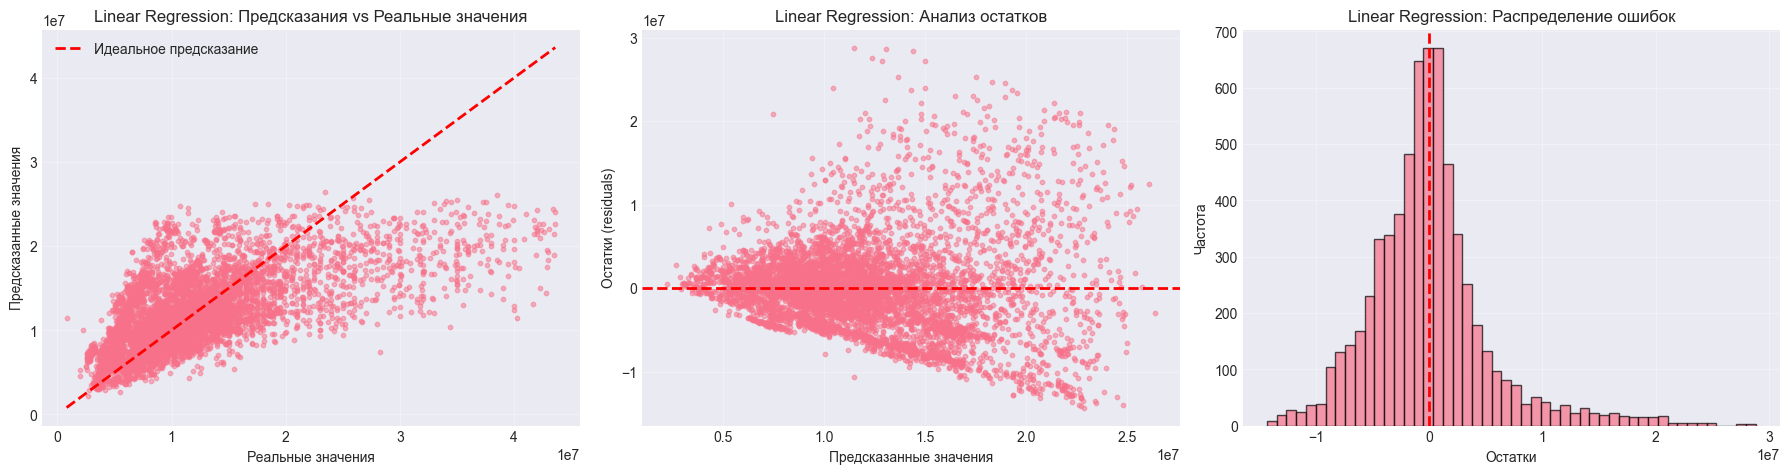


📈 Процентильные ошибки (%):
  10%:  4.01%
  25%:  10.09%
  50%:  23.36%
  75%:  44.15%
  90%:  91.49%
  95%:  114.84%
  99%:  153.81%


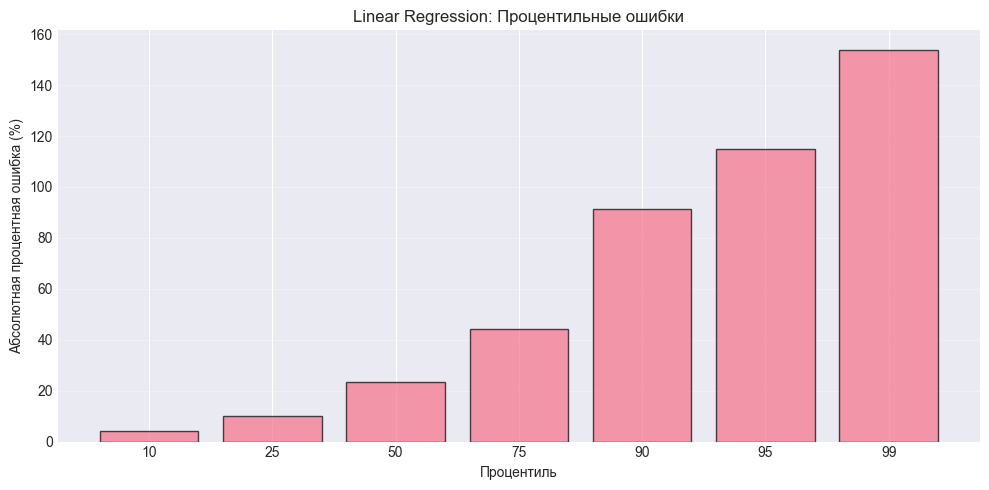



Тестирование модели: Random Forest

Анализ модели: Random Forest

📊 Метрики на тестовой выборке:
  MAE:  2,034,532 ₽
  RMSE: 3,457,396 ₽
  R²:   0.7408
  MAPE: 16.32%


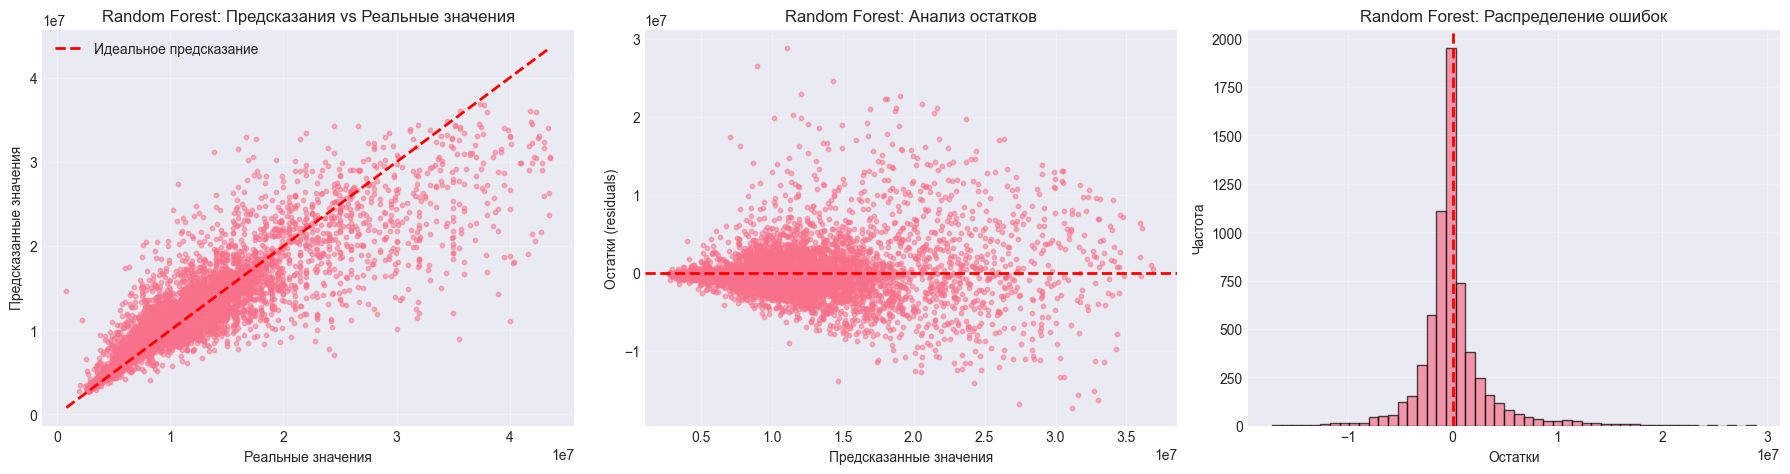


📈 Процентильные ошибки (%):
  10%:  1.59%
  25%:  4.29%
  50%:  10.64%
  75%:  21.34%
  90%:  36.22%
  95%:  48.55%
  99%:  89.06%


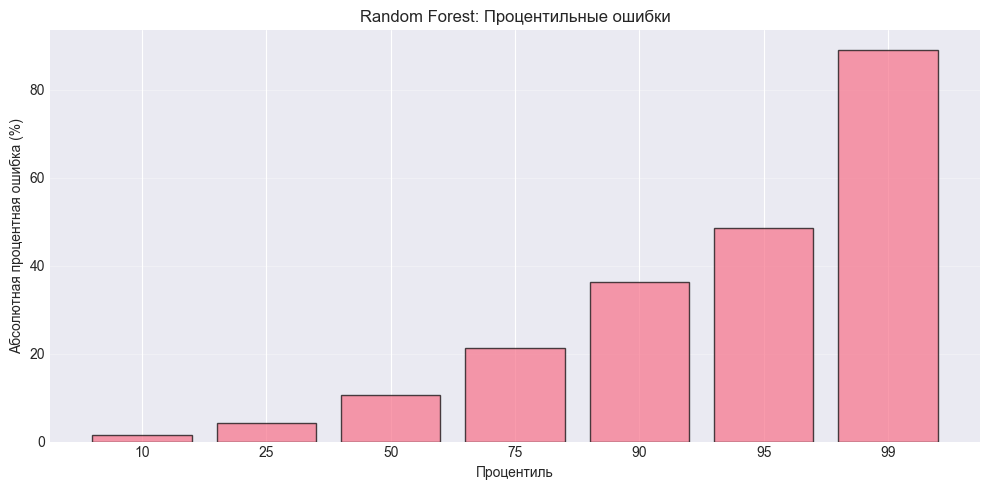



Тестирование модели: Gradient Boosting

Анализ модели: Gradient Boosting

📊 Метрики на тестовой выборке:
  MAE:  2,249,389 ₽
  RMSE: 3,629,454 ₽
  R²:   0.7144
  MAPE: 18.72%


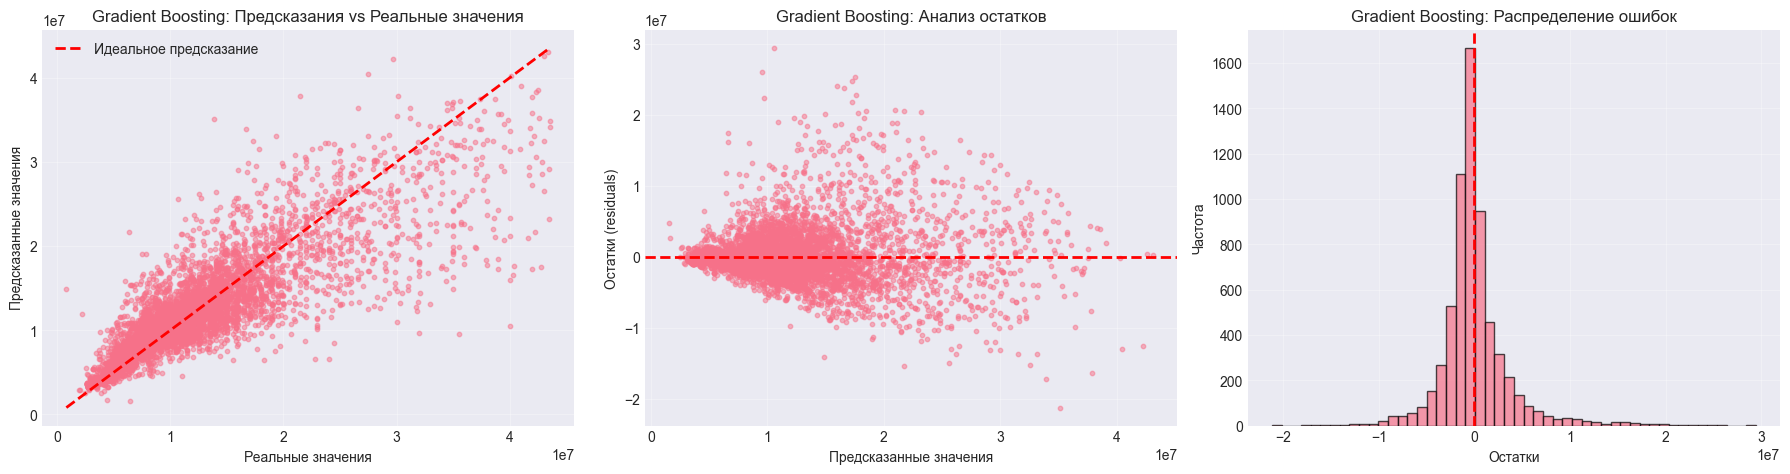


📈 Процентильные ошибки (%):
  10%:  2.42%
  25%:  5.90%
  50%:  13.21%
  75%:  24.94%
  90%:  39.82%
  95%:  52.30%
  99%:  90.29%


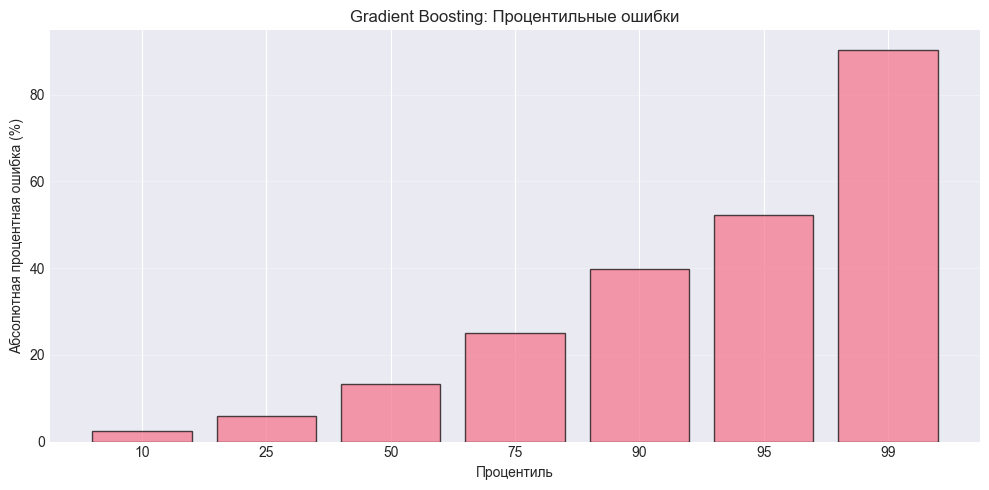



Тестирование модели: XGBoost

Анализ модели: XGBoost

📊 Метрики на тестовой выборке:
  MAE:  2,174,780 ₽
  RMSE: 3,563,171 ₽
  R²:   0.7247
  MAPE: 17.91%


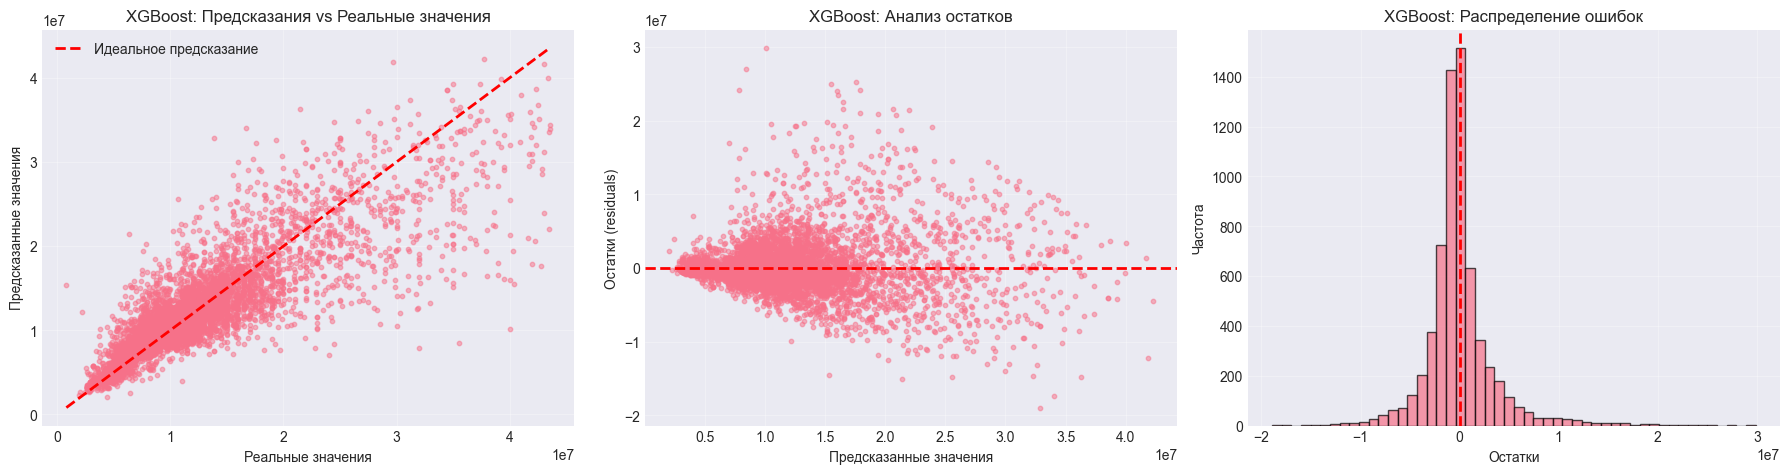


📈 Процентильные ошибки (%):
  10%:  1.92%
  25%:  5.39%
  50%:  12.43%
  75%:  23.66%
  90%:  37.73%
  95%:  51.62%
  99%:  89.22%


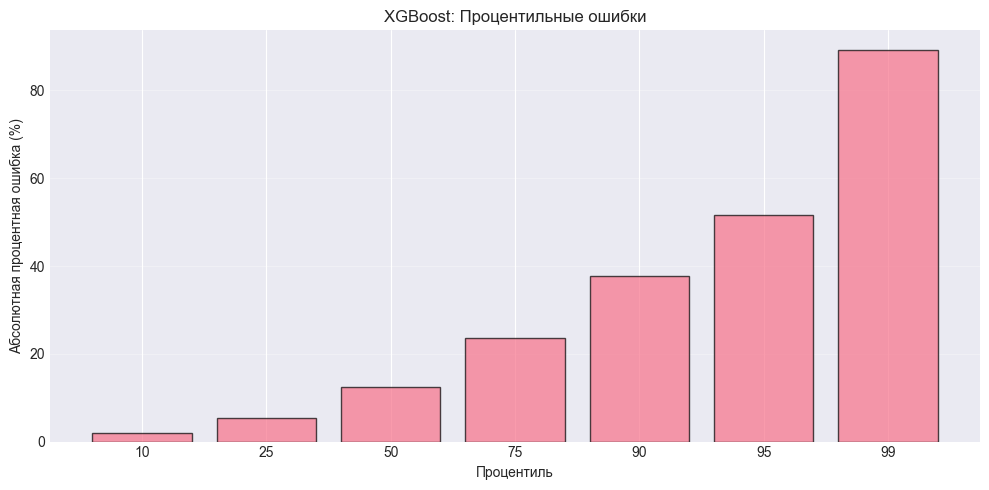



Тестирование модели: LightGBM

Анализ модели: LightGBM

📊 Метрики на тестовой выборке:
  MAE:  2,191,387 ₽
  RMSE: 3,588,138 ₽
  R²:   0.7208
  MAPE: 18.14%


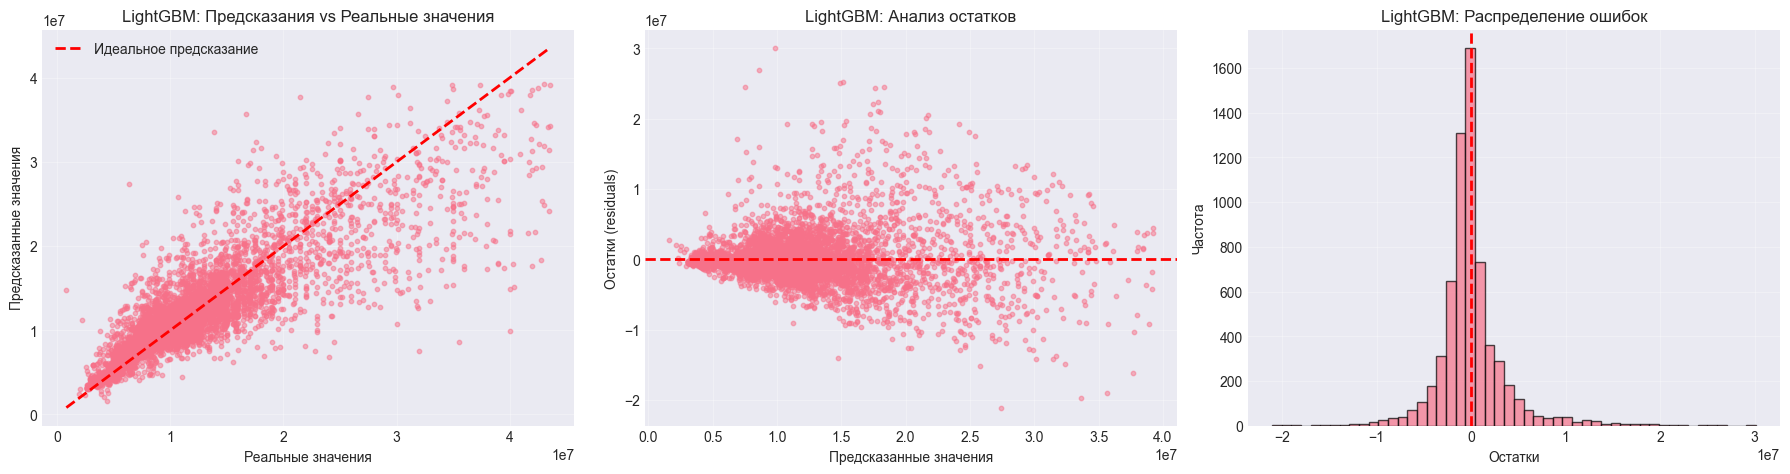


📈 Процентильные ошибки (%):
  10%:  2.08%
  25%:  5.41%
  50%:  12.60%
  75%:  24.02%
  90%:  38.97%
  95%:  51.54%
  99%:  92.85%


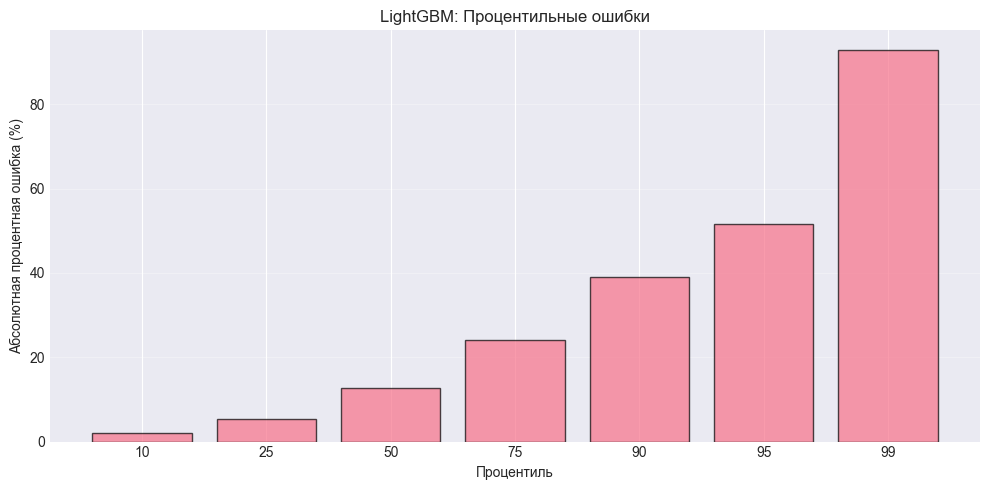



Тестирование модели: CatBoost

Анализ модели: CatBoost

📊 Метрики на тестовой выборке:
  MAE:  2,129,047 ₽
  RMSE: 3,515,596 ₽
  R²:   0.7320
  MAPE: 17.52%


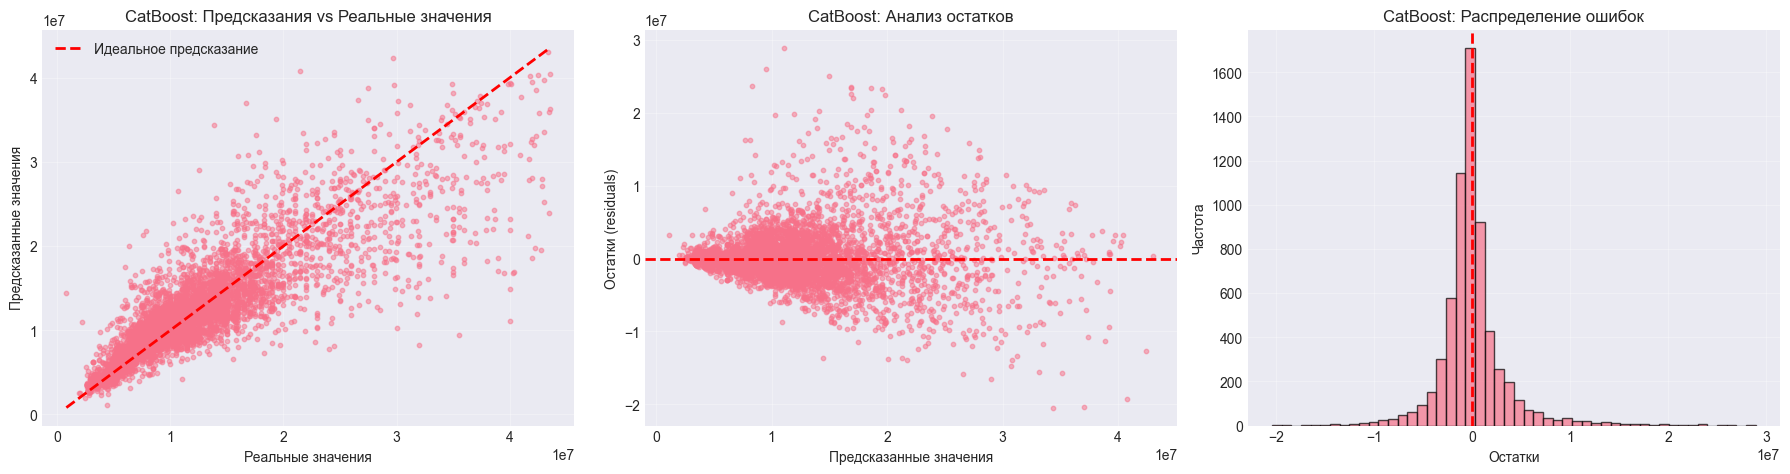


📈 Процентильные ошибки (%):
  10%:  2.03%
  25%:  5.19%
  50%:  11.99%
  75%:  23.25%
  90%:  37.35%
  95%:  49.92%
  99%:  89.88%


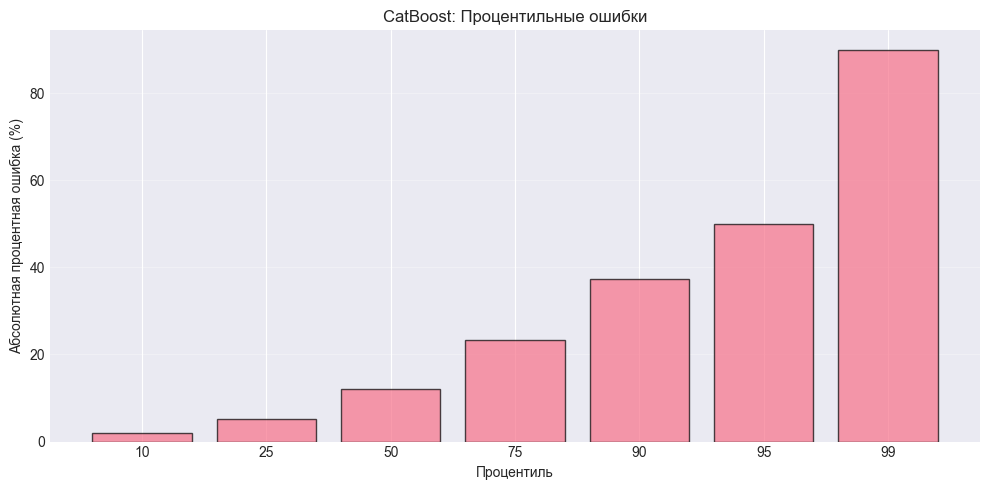



Тестирование модели: SVR

Анализ модели: SVR

📊 Метрики на тестовой выборке:
  MAE:  4,557,242 ₽
  RMSE: 6,974,275 ₽
  R²:   -0.0546
  MAPE: 40.21%


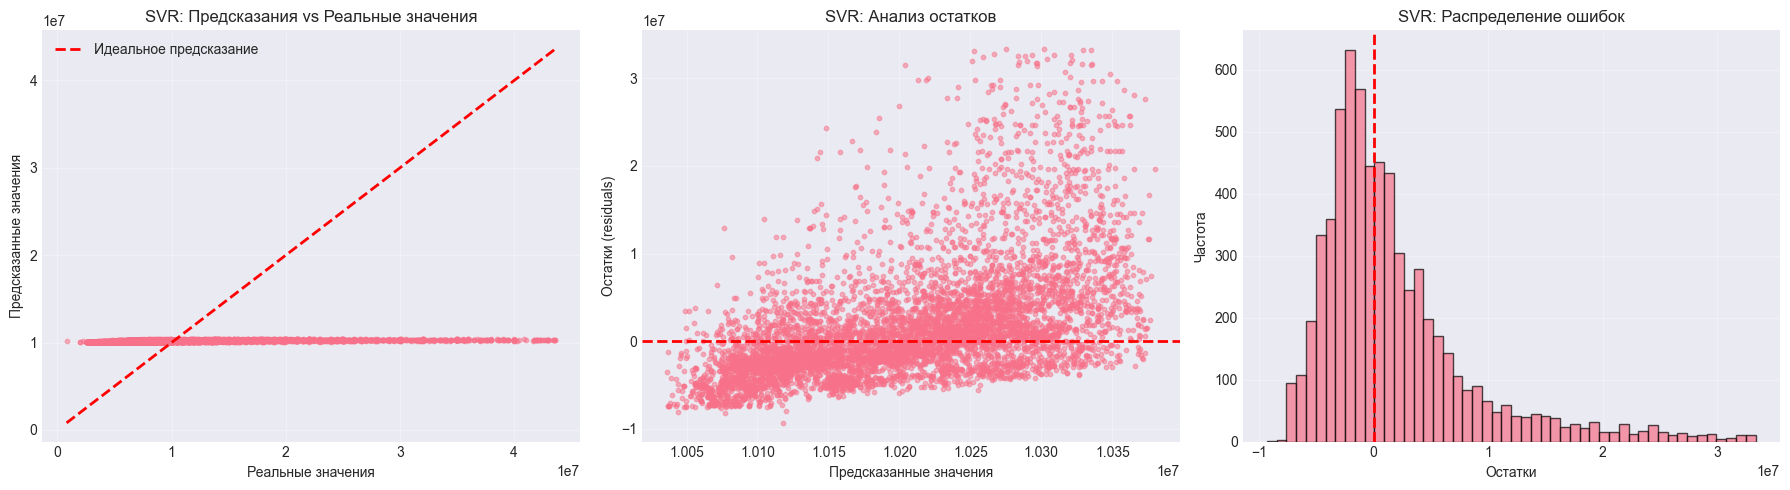


📈 Процентильные ошибки (%):
  10%:  6.44%
  25%:  14.54%
  50%:  29.60%
  75%:  51.75%
  90%:  76.35%
  95%:  108.48%
  99%:  231.37%


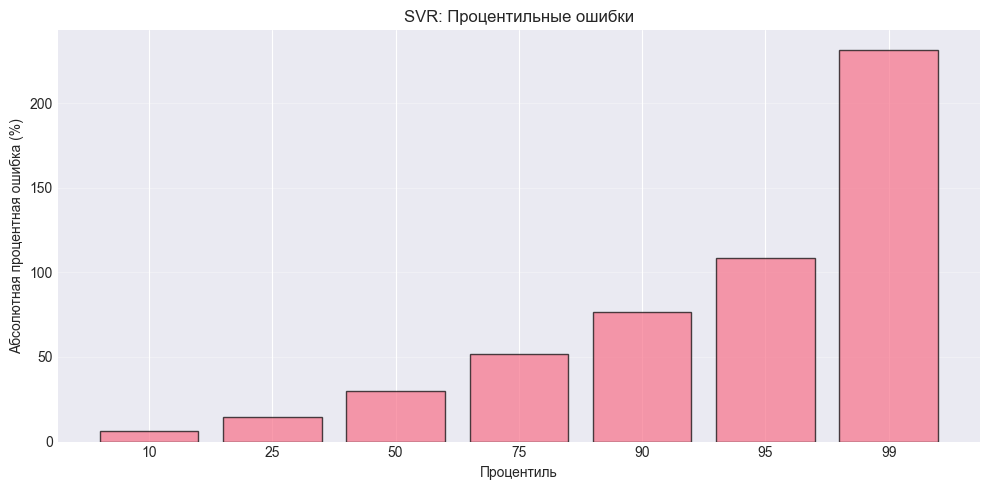

In [24]:
# Оценка всех моделей на тестовой выборке
test_results = {}

# Словарь моделей
models = {
    'Linear Regression': lr_model,
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model,
    'XGBoost': xgb_model,
    'LightGBM': lgbm_model,
    'CatBoost': catboost_model,
    'SVR': svr_model
}

# Оценка каждой модели
for model_name, model in models.items():
    print(f"\n{'='*80}")
    print(f"Тестирование модели: {model_name}")
    print(f"{'='*80}")
    
    test_metrics = analyze_model_results(
        model=model,
        X_test=X_test_scaled,
        y_test=y_test.values,
        model_name=model_name
    )
    
    test_results[model_name] = test_metrics

## 8. Выбор лучшей модели


In [25]:
# Создание сравнительной таблицы
comparison_data = []

model_names = ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM', 'CatBoost', 'SVR']

for model_name in model_names:
    row = {
        'Модель': model_name,
        'Train MAE': all_results[model_name]['train_metrics']['mae'],
        'Train RMSE': all_results[model_name]['train_metrics']['rmse'],
        'Train R²': all_results[model_name]['train_metrics']['r2'],
        'Val MAE': all_results[model_name]['val_metrics']['mae'],
        'Val RMSE': all_results[model_name]['val_metrics']['rmse'],
        'Val R²': all_results[model_name]['val_metrics']['r2'],
        'Test MAE': test_results[model_name]['mae'],
        'Test RMSE': test_results[model_name]['rmse'],
        'Test R²': test_results[model_name]['r2'],
        'Test MAPE': test_results[model_name]['mape']
    }
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*120)
print(" "*40 + "СРАВНЕНИЕ МОДЕЛЕЙ")
print("="*120)
print(comparison_df.to_string(index=False))
print("="*120)


                                        СРАВНЕНИЕ МОДЕЛЕЙ
           Модель  Train MAE  Train RMSE  Train R²    Val MAE   Val RMSE  Val R²   Test MAE  Test RMSE  Test R²  Test MAPE
Linear Regression 3704326.25  5357231.55      0.40 3844242.77 5554736.61    0.35 3693086.97 5316155.59     0.39      34.97
    Random Forest 1395263.22  2317404.00      0.89 2140646.26 3665481.49    0.72 2034531.57 3457396.47     0.74      16.32
Gradient Boosting 2040244.78  3183064.77      0.79 2385038.66 3869861.13    0.68 2249389.04 3629454.27     0.71      18.72
          XGBoost 1885514.77  2951462.83      0.82 2308598.49 3804573.39    0.69 2174779.63 3563171.15     0.72      17.91
         LightGBM 2017797.35  3188167.35      0.79 2346898.72 3844891.50    0.69 2191386.91 3588138.15     0.72      18.14
         CatBoost 1840345.10  2880057.57      0.83 2268365.54 3741316.79    0.70 2129046.57 3515595.54     0.73      17.52
              SVR 4583506.41  7080013.02     -0.05 4568777.55 7031366.98   -0.05

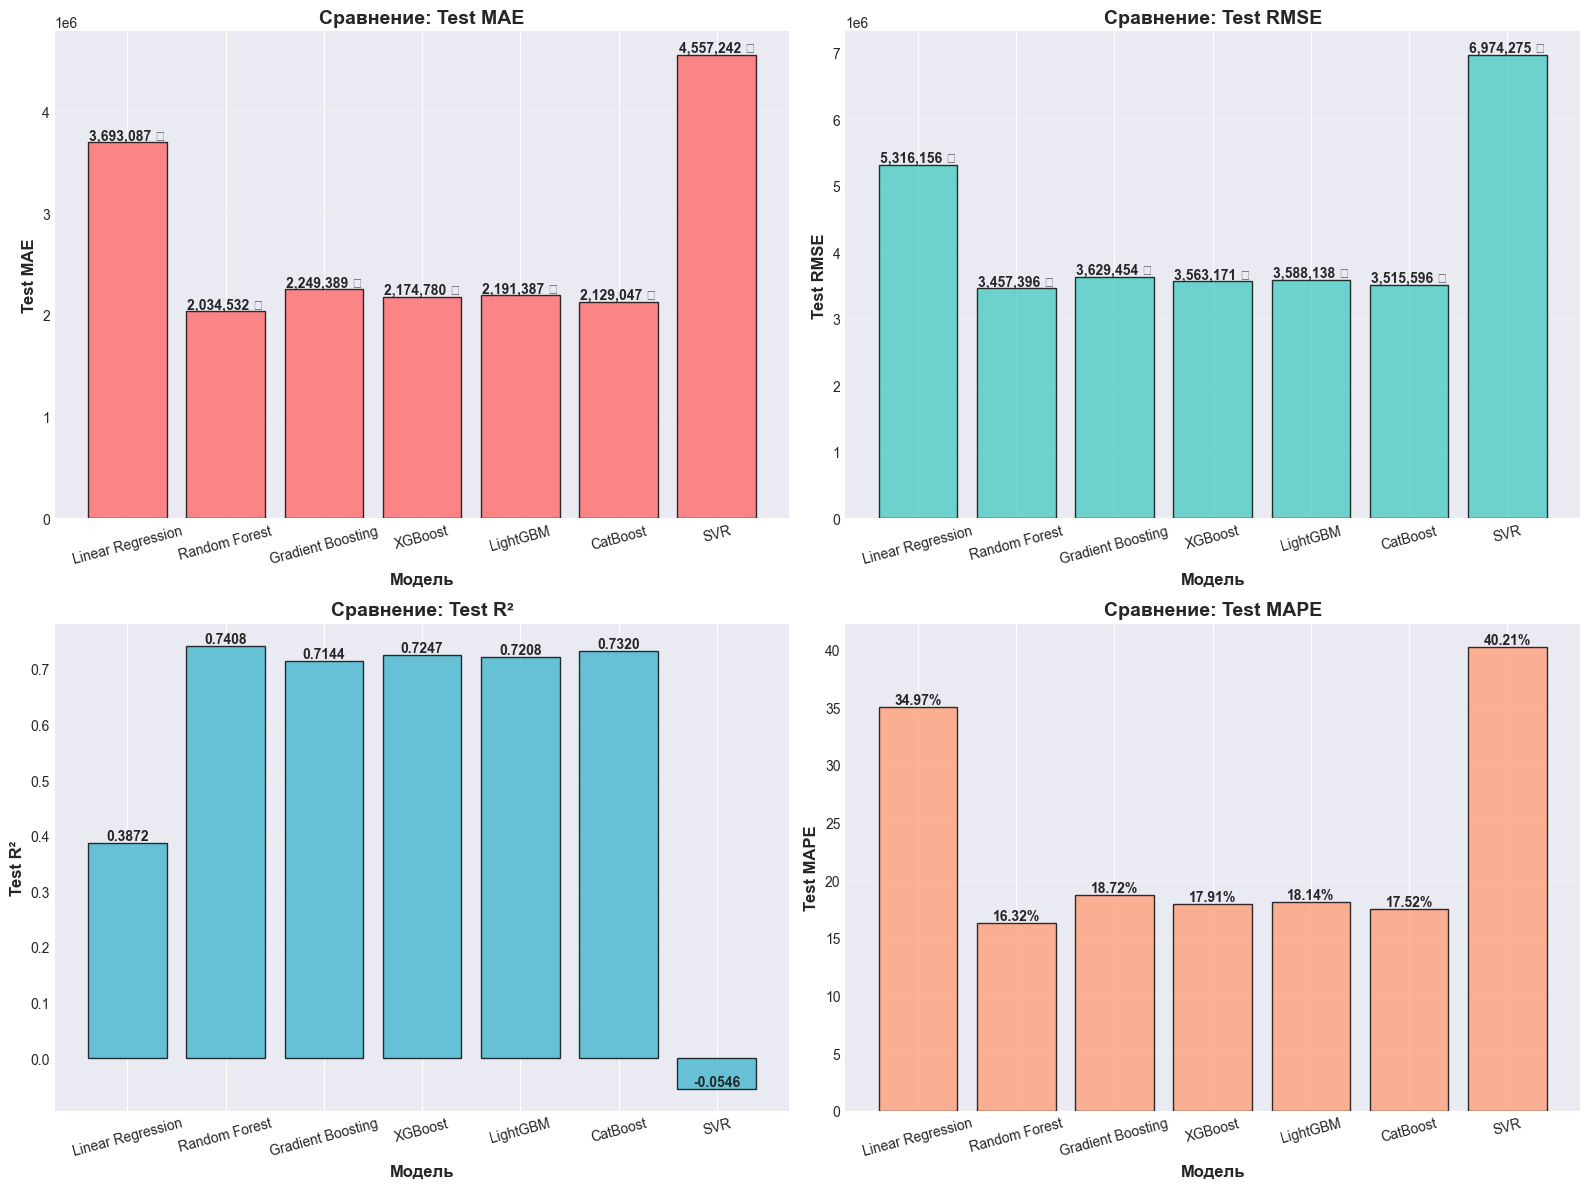

In [26]:
# Визуализация сравнения моделей
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics_to_plot = ['Test MAE', 'Test RMSE', 'Test R²', 'Test MAPE']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

for idx, (ax, metric) in enumerate(zip(axes.flatten(), metrics_to_plot)):
    values = comparison_df[metric].values
    model_names = comparison_df['Модель'].values
    
    bars = ax.bar(model_names, values, color=colors[idx], alpha=0.8, edgecolor='black')
    ax.set_xlabel('Модель', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'Сравнение: {metric}', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Добавление значений на столбцах
    for bar in bars:
        height = bar.get_height()
        if 'R²' in metric:
            label = f'{height:.4f}'
        elif 'MAPE' in metric:
            label = f'{height:.2f}%'
        else:
            label = f'{height:,.0f} ₽'
        ax.text(bar.get_x() + bar.get_width()/2., height,
                label, ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()


In [27]:
# Определение лучшей модели
best_model_name = comparison_df.loc[comparison_df['Test R²'].idxmax(), 'Модель']
best_r2 = comparison_df.loc[comparison_df['Test R²'].idxmax(), 'Test R²']
best_mae = comparison_df.loc[comparison_df['Test MAE'].idxmin(), 'Test MAE']
best_model_by_mae = comparison_df.loc[comparison_df['Test MAE'].idxmin(), 'Модель']

print("\n" + "="*80)
print(" "*25 + "🏆 ИТОГОВЫЕ РЕЗУЛЬТАТЫ 🏆")
print("="*80)
print(f"\n✅ Лучшая модель по R²:  {best_model_name} (R² = {best_r2:.4f})")
print(f"✅ Лучшая модель по MAE: {best_model_by_mae} (MAE = {best_mae:,.0f} ₽)")

# Детальная информация о лучшей модели
best_model_info = comparison_df[comparison_df['Модель'] == best_model_name].iloc[0]

print(f"\n📊 Детальные метрики лучшей модели ({best_model_name}):")
print(f"\n  Обучающая выборка:")
print(f"    MAE:  {best_model_info['Train MAE']:,.0f} ₽")
print(f"    RMSE: {best_model_info['Train RMSE']:,.0f} ₽")
print(f"    R²:   {best_model_info['Train R²']:.4f}")
print(f"\n  Валидационная выборка:")
print(f"    MAE:  {best_model_info['Val MAE']:,.0f} ₽")
print(f"    RMSE: {best_model_info['Val RMSE']:,.0f} ₽")
print(f"    R²:   {best_model_info['Val R²']:.4f}")
print(f"\n  Тестовая выборка:")
print(f"    MAE:  {best_model_info['Test MAE']:,.0f} ₽")
print(f"    RMSE: {best_model_info['Test RMSE']:,.0f} ₽")
print(f"    R²:   {best_model_info['Test R²']:.4f}")
print(f"    MAPE: {best_model_info['Test MAPE']:.2f}%")

print("\n" + "="*80)
print(f"\n💾 Все модели сохранены в: {MODELS_DIR}")
print(f"\n✅ Обучение завершено успешно!")
print("="*80)



                         🏆 ИТОГОВЫЕ РЕЗУЛЬТАТЫ 🏆

✅ Лучшая модель по R²:  Random Forest (R² = 0.7408)
✅ Лучшая модель по MAE: Random Forest (MAE = 2,034,532 ₽)

📊 Детальные метрики лучшей модели (Random Forest):

  Обучающая выборка:
    MAE:  1,395,263 ₽
    RMSE: 2,317,404 ₽
    R²:   0.8871

  Валидационная выборка:
    MAE:  2,140,646 ₽
    RMSE: 3,665,481 ₽
    R²:   0.7159

  Тестовая выборка:
    MAE:  2,034,532 ₽
    RMSE: 3,457,396 ₽
    R²:   0.7408
    MAPE: 16.32%


💾 Все модели сохранены в: /Users/nznyx/Documents/ml/dir/DeruzhinksiiTokarevProjectML/models

✅ Обучение завершено успешно!


In [28]:
# Сохранение результатов в JSON
results_summary = {
    'models': {},
    'best_model': {
        'name': best_model_name,
        'test_r2': float(best_r2),
        'test_mae': float(best_mae)
    },
    'dataset_info': {
        'total_samples': len(df),
        'train_samples': len(X_train),
        'val_samples': len(X_val),
        'test_samples': len(X_test),
        'features': list(X.columns)
    }
}

model_names = ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM', 'CatBoost', 'SVR']

for model_name in model_names:
    results_summary['models'][model_name] = {
        'train': {k: float(v) for k, v in all_results[model_name]['train_metrics'].items()},
        'val': {k: float(v) for k, v in all_results[model_name]['val_metrics'].items()},
        'test': {k: float(v) for k, v in test_results[model_name].items()}
    }

# Сохранение в файл
results_path = MODELS_DIR / "training_results.json"
with open(results_path, 'w', encoding='utf-8') as f:
    json.dump(results_summary, f, indent=2, ensure_ascii=False)

print(f"✅ Результаты сохранены в: {results_path}")

✅ Результаты сохранены в: /Users/nznyx/Documents/ml/dir/DeruzhinksiiTokarevProjectML/models/training_results.json
